In [3]:
from utils import *
from alignment import *
import time

In [ ]:
dataset_path = "Data/ShapeNetSem/Datasets/final_template.csv"
image_dir = "Data/ShapeNetSem/Images/final_subset/"
pc_dir = "Data/ProcessedData/PointCloudsFinal/"

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for idx, mesh_id, token_text, image_tensor, point_cloud in dataloader:
    print(idx)
    print(f"Tokenized Text: {token_text.shape}, {type(token_text)}")
    print(f"Image Tensor: {image_tensor.shape}, {type(image_tensor)}")
    print(f"Point Cloud: {point_cloud.shape}, {type(point_cloud)}")
    break

tensor([270])
Tokenized Text: torch.Size([1, 77]), <class 'torch.Tensor'>
Image Tensor: torch.Size([1, 3, 518, 518]), <class 'torch.Tensor'>
Point Cloud: torch.Size([1, 1024, 3]), <class 'torch.Tensor'>


In [5]:
try:
    dinov2_encoder = load_dinov2()
    clip_encoder = load_clip()
    pclip_encoder = load_point_clip()
    dinov2_encoder.eval()
    clip_encoder.eval()
    pclip_encoder.eval()
    print('All Models loaded succesfully and set to eval mode')
except:
    print('Error in Loading Models')

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
All Models loaded succesfully and set to eval mode


In [7]:
# Initialize the model
align_model = AlignEncoder(400)  # Ensure the architecture matches

# Load the saved weights
checkpoint_path = "TrainedModels/ALIGN/Baseline/150.pth"
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Load to CPU

# Apply the weights to the model
align_model.load_state_dict(state_dict)

# Set to evaluation mode (if needed)
align_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
align_model.to(device)

print("Model weights loaded successfully!")


Model weights loaded successfully!


Forward Pass

In [ ]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
image_dir = "Data/ShapeNetSem/Images/subset_200"
pc_dir = "Data/ProcessedData/PointClouds"

# Set up CLIP preprocessing
preprocess = image_transform(
    clip_encoder.visual.image_size,  # Correct image size for CLIP
    is_train=False  # Ensures we use inference preprocessing
)

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
loss_fn = NTXentLoss(temperature=0.07)

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        idx, mesh_id, tokenized_text, image_tensor, point_cloud = batch
        tokenized_text = tokenized_text.to(device) # (B, 77)
        image_tensor = image_tensor.to(device) # (B, 3, 518, 518)

        point_cloud = point_cloud.to(device) # (B, 1024, 3)

        # Assuming point_cloud is a batch of point clouds (shape: [batch_size, N, 3])
        batch_size = point_cloud.shape[0]
        start_time = time.time()
        # Convert each point cloud to a depth map and preprocess it
        depth_maps = [preprocess(point_cloud_to_depth_map(point_cloud[i])).unsqueeze(0) for i in range(batch_size)]

        # Stack depth maps into a single batch tensor
        depth_maps = torch.cat(depth_maps, dim=0).to(device)  # Shape: [batch_size, 3, H, W]

        text_emb = clip_encoder.encode_text(tokenized_text) # (B, 768)
        img_emb = dinov2_encoder(image_tensor) # (B, 384)
        pc_emb = pclip_encoder.encode_image(depth_maps) # (B, 768)
        end_time = time.time()
        print(f'Encoding: {readable_time(start_time, end_time)}')
        start_time = time.time()
        text_proj, img_proj, pc_proj = align_model(text_emb, img_emb, pc_emb)
        end_time = time.time()
        print(f'Projection: {readable_time(start_time, end_time)}')
        loss_text_point = loss_fn(text_proj, pc_proj)
        loss_text_image = loss_fn(text_proj, img_proj)
        loss_image_point = loss_fn(img_proj, pc_proj)

        avg_loss = (loss_text_point + loss_text_image + loss_image_point) / 3
        """
        print("Input shapes: ", tokenized_text.shape, image_tensor.shape, point_cloud.shape)
        print("Depth Map Shapes: ", depth_maps.shape)
        print("Embedding shapes: ", text_emb.shape, img_emb.shape, pc_emb.shape)
        print("Projection Shapes: ", text_proj.shape, img_proj.shape, pc_proj.shape)
        print("Loss: ", loss_text_point, loss_text_image, loss_image_point)
        print("Average Loss: ",avg_loss)
        """  
        break  

Encoding: 00:00:11
Projection: 00:00:00


# Cross Modal Retrieval

In [2]:
from alignment import *
from dataset import *
import torch

In [37]:
checkpoint_path = "TrainedModels/ALIGN/NormalTrain/10.pth"
dataset_path = "Data/ShapeNetSem/Datasets/final_train.csv"
image_dir = "Data/ShapeNetSem/Images/final_subset"
pc_dir = "Data/ProcessedData/PointCloudsFinal"
exp_name = "train"
embed_path = f"TrainedModels/ALIGN/NormalTrain/{exp_name}.pt"

cmr = CrossModalRetrival(dataset_path, embed_path)

In [38]:
try:
    dinov2_encoder = load_dinov2()
    clip_encoder = load_clip()
    pclip_encoder = load_point_clip()
    dinov2_encoder.eval()
    clip_encoder.eval()
    pclip_encoder.eval()
    print('All Models loaded succesfully and set to eval mode')
except:
    print('Error in Loading Models')

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!
All Models loaded succesfully and set to eval mode


In [39]:
align_model = AlignEncoder(400)  # Ensure the architecture matches

# Load the saved weights
state_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))  # Load to CPU

# Apply the weights to the model
align_model.load_state_dict(state_dict)

# Set to evaluation mode (if needed)
align_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
align_model.to(device)

AlignEncoder(
  (text_proj_head): MLP(
    (net): Sequential(
      (0): Linear(in_features=768, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=400, bias=True)
    )
  )
  (img_proj_head): MLP(
    (net): Sequential(
      (0): Linear(in_features=384, out_features=768, bias=True)
      (1): ReLU()
      (2): Linear(in_features=768, out_features=400, bias=True)
    )
  )
  (pc_proj_head): MLP(
    (net): Sequential(
      (0): Linear(in_features=768, out_features=1536, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1536, out_features=400, bias=True)
    )
  )
)

In [54]:
# Set up CLIP preprocessing
preprocess = image_transform(
    clip_encoder.visual.image_size,  # Correct image size for CLIP
    is_train=False  # Ensures we use inference preprocessing
)

dataset = AlignedModalityDataset(dataset_path, image_dir, pc_dir)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
device = "cuda" if torch.cuda.is_available() else "cpu"

with torch.no_grad():
    for i, batch in enumerate(dataloader):
        idx, tokenized_text, image_tensor, point_cloud = batch
        tokenized_text = tokenized_text.to(device) # (B, 77)
        image_tensor = image_tensor.to(device) # (B, 3, 518, 518)
        print(tokenized_text.shape, image_tensor.shape, point_cloud.shape)
        point_cloud = point_cloud.to(device) # (B, 1024, 3)

        # Assuming point_cloud is a batch of point clouds (shape: [batch_size, N, 3])
        batch_size = point_cloud.shape[0]

        # Convert each point cloud to a depth map and preprocess it
        depth_maps = [preprocess(point_cloud_to_depth_map(point_cloud[i])).unsqueeze(0) for i in range(batch_size)]

        # Stack depth maps into a single batch tensor
        depth_maps = torch.cat(depth_maps, dim=0).to(device)  # Shape: [batch_size, 3, H, W]

        text_emb = clip_encoder.encode_text(tokenized_text) # (B, 768)
        img_emb = dinov2_encoder(image_tensor) # (B, 384)
        pc_emb = pclip_encoder.encode_image(depth_maps) # (B, 768)
        text_proj, img_proj, pc_proj = align_model(text_emb, img_emb, pc_emb)

        break  

torch.Size([1, 77]) torch.Size([1, 3, 518, 518]) torch.Size([1, 1024, 3])


In [55]:
df = pd.read_csv(dataset_path)
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
279,867d9945687ada13bb62a53e25c6d701,Speaker,speaker,NaN,"['loudspeaker,speaker,speaker unit,loudspeaker...",['electro-acoustic transducer that converts el...,A speaker which is commonly known as <no_tags>...,"The speaker is a loudspeaker,speaker,speaker u...","speaker is a loudspeaker,speaker,speaker unit,..."


In [56]:
# retrieve(self, query, query_modality, target_modality, top_k=5)
idx, mesh_ids, projs = cmr.retrieve(text_proj, 'text', 'pc', 5)
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
1105,4ca670411a191a11df0c7dbe7f8f4c8e,"Speaker,_StanfordSceneDBModels,_SceneGalleryMo...",speakers,"black,computer,nice,ok,simple,speaker","['loudspeaker,speaker,speaker unit,loudspeaker...",['electro-acoustic transducer that converts el...,"A speakers which is commonly known as black,co...","The speakers is a loudspeaker,speaker,speaker ...","speakers is a loudspeaker,speaker,speaker unit..."
845,f7bc71483088b9192150cf14c949b016,"Lamp,TableLamp",table lamp,"ampe,antique,art,desk lamp,eco friendly,electr...","['lamp', 'table lamp']",['a piece of furniture holding one or more ele...,"A table lamp which is commonly known as ampe,a...","The table lamp is a lamp, table lamp often use...","table lamp is a lamp, table lamp designed for ..."
185,fb55535403fa30d2e1f3ca9fa5f82562,"Stool,Barstool,_AttributesTrain",modern barstool,"barstool,modern barstool,saddle barstool,zuo m...",['stool'],['a simple seat without a back or arms'],A modern barstool which is commonly known as b...,The modern barstool is a stool often used for ...,modern barstool is a stool designed for barsto...
755,75dd1eb981f15ad166ab797924e689f7,"DrinkingUtensil,Cup",milk,"glass,milk","['container', 'cup']",['any object that can be used to hold things (...,"A milk which is commonly known as glass,milk. ...","The milk is a container, cup often used for gl...","milk is a container, cup designed for glass,mi..."
1062,9efec9640e11cb19e7e684d25d4dcaf0,"Lamp,TableLamp",lamp,*,"['lamp', 'table lamp']",['a piece of furniture holding one or more ele...,A lamp which is commonly known as <no_tags>. I...,"The lamp is a lamp, table lamp often used for ...","lamp is a lamp, table lamp designed for <no_ta..."


In [57]:
# retrieve(self, query, query_modality, target_modality, top_k=5)
idx, mesh_ids, projs = cmr.retrieve(img_proj, 'img', 'pc', 5)
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
1117,4784aeb9d867aa83f685327911e7e258,PottedPlant,vase of roses,"flower,flower with stem,red rose,rose,rose wit...","['plant,flora,plant life']",['(botany) a living organism lacking the power...,A vase of roses which is commonly known as flo...,"The vase of roses is a plant,flora,plant life ...","vase of roses is a plant,flora,plant life desi..."
511,667feb014ec060c4855931d119219022,"Table,AccentTable,RoundTable",ekitta saturn end table,"ekitta,end table,saturn,table",['table'],['a piece of furniture having a smooth flat to...,A ekitta saturn end table which is commonly kn...,The ekitta saturn end table is a table often u...,ekitta saturn end table is a table designed fo...
1105,4ca670411a191a11df0c7dbe7f8f4c8e,"Speaker,_StanfordSceneDBModels,_SceneGalleryMo...",speakers,"black,computer,nice,ok,simple,speaker","['loudspeaker,speaker,speaker unit,loudspeaker...",['electro-acoustic transducer that converts el...,"A speakers which is commonly known as black,co...","The speakers is a loudspeaker,speaker,speaker ...","speakers is a loudspeaker,speaker,speaker unit..."
1188,59051ac1a34906c65e7087f2d9a278a9,"Table,AccentTable,RoundTable",glass end table,"end,glass,in,short,table,wood",['table'],['a piece of furniture having a smooth flat to...,A glass end table which is commonly known as e...,The glass end table is a table often used for ...,"glass end table is a table designed for end,gl..."
1087,135edda466e3b149df63d1c7e43c783f,"Table,RoundTable",sa,"eero saarinen,low table,matrix international,t...",['table'],['a piece of furniture having a smooth flat to...,"A sa which is commonly known as eero saarinen,...",The sa is a table often used for eero saarinen...,"sa is a table designed for eero saarinen,low t..."


In [58]:
# retrieve(self, query, query_modality, target_modality, top_k=5)
idx, mesh_ids, projs = cmr.retrieve(pc_proj, 'pc', 'pc', 5)
df.iloc[idx]

,fullId,category,name,tags,synset words,synset gloss,template1_desc,template2_desc,template3_desc
1087,135edda466e3b149df63d1c7e43c783f,"Table,RoundTable",sa,"eero saarinen,low table,matrix international,t...",['table'],['a piece of furniture having a smooth flat to...,"A sa which is commonly known as eero saarinen,...",The sa is a table often used for eero saarinen...,"sa is a table designed for eero saarinen,low t..."
1062,9efec9640e11cb19e7e684d25d4dcaf0,"Lamp,TableLamp",lamp,*,"['lamp', 'table lamp']",['a piece of furniture holding one or more ele...,A lamp which is commonly known as <no_tags>. I...,"The lamp is a lamp, table lamp often used for ...","lamp is a lamp, table lamp designed for <no_ta..."
1188,59051ac1a34906c65e7087f2d9a278a9,"Table,AccentTable,RoundTable",glass end table,"end,glass,in,short,table,wood",['table'],['a piece of furniture having a smooth flat to...,A glass end table which is commonly known as e...,The glass end table is a table often used for ...,"glass end table is a table designed for end,gl..."
872,4b92aa95cc2210c3f017dd57a82a3a39,"Table,DiningTable,RoundTable",saarinen table,"saarinen,table","['table', 'dining table,board']",['a piece of furniture having a smooth flat to...,A saarinen table which is commonly known as sa...,"The saarinen table is a table, dining table,bo...","saarinen table is a table, dining table,board ..."
575,78d63ed70da7a72b12b15725a9f15150,"Table,AccentTable",round end table,"end table,round table,table",['table'],['a piece of furniture having a smooth flat to...,A round end table which is commonly known as e...,The round end table is a table often used for ...,round end table is a table designed for end ta...


In [72]:
mesh_ids

185    3d1e2c8874e4ed51dc3d5b9de4300711
280    3e9f3db3935fbf37b6da6aba4787946b
55     1a30adabf5a2bb848af30108ea9ccb6c
142    d79ad0a65a00809f3a66b6fe2c876ded
126    cd1e911b8571721998d5fc0473d00a1c
Name: fullId, dtype: object

In [ ]:
from alignment import *
from utils import *

class EncodeUserInput(nn.Module):
    def __init__(self, align_path="TrainedModels/Baseline/150.pth", align_embd=400):
        super().__init__()
        self.align_path = align_path
        self.align_embd = align_embd

        self.clip_encoder = None

        # Loading models
        self.load_models()

        # Preprocessing functions
        self.tokenizer = open_clip.tokenize
        self.transform = transforms.Compose([
            transforms.Resize((518, 518)),  # Resize to DINO's expected input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # DINOv2 normalization
        ])
        self.pclip_preprocess = image_transform(
            self.clip_encoder.visual.image_size,  # Correct image size for CLIP
            is_train=False  # Ensures we use inference preprocessing
        )

    def preprocess_text(self, text_prompt):
        max_length = 77
        tokenized_text = self.tokenizer([text_prompt])
        #print(tokenized_text.shape)
        return tokenized_text

    def preprocess_img(self, img_prompt):
        image_tensor = self.transform(img_prompt).unsqueeze(0)
        #print(image_tensor.shape)
        return image_tensor

    def preprocess_pc(self, pc_prompt):
        num_points = 1024
        indices = np.random.choice(pc_prompt.shape[0], num_points, replace=False)
        # Sample the selected points
        sampled_pc = pc_prompt[indices]
        depth_map = self.pclip_preprocess(point_cloud_to_depth_map(sampled_pc)).unsqueeze(0)  # Add batch dimension
        return depth_map

    def preprocess_input(self, prompt, modality):
        if modality == "text":
            processed_output = self.preprocess_text(prompt)
        elif modality == "img":
            processed_output = self.preprocess_img(prompt)
        else:
            processed_output = self.preprocess_pc(prompt)
        return processed_output
    
    def load_models(self):
        try:
            self.dinov2_encoder = load_dinov2()
            self.clip_encoder = load_clip()
            self.pclip_encoder = load_point_clip()
            self.align_model = load_alignment(self.align_path, self.align_embd)
            self.dinov2_encoder.eval()
            self.clip_encoder.eval()
            self.pclip_encoder.eval()
            self.align_model.eval()
        except:
            print('Error in Loading Models')
    
    def get_projection(self, prompt, modality):
        preprocessed_prompt = self.preprocess_input(prompt, modality)

        with torch.no_grad():
            if modality == "text":
                embedding = self.clip_encoder.encode_text(preprocessed_prompt)
                projection = self.align_model.text_proj_head(embedding)
            elif modality == "img":
                embedding = self.dinov2_encoder(preprocessed_prompt)
                projection = self.align_model.img_proj_head(embedding)
            else:
                embedding = self.pclip_encoder.encode_image(preprocessed_prompt)
                projection = self.align_model.pc_proj_head(embedding)

        return projection

In [79]:
import pandas as pd

In [80]:
dataset_path = "Data/ShapeNetSem/Datasets/subset_template_200.csv"
embed_path = "Embeddings/ALIGN/subset_template_200.pt"

df = pd.read_csv(dataset_path)

In [81]:
row = df.iloc[0]

mesh_id = row['fullId']
text = row['template1_desc']
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_id}/view0.png'
image = Image.open(img_path).convert('RGB')
pc_path = f'Data/ProcessedData/PointClouds/{mesh_id}.npy'
pc = torch.from_numpy(np.load(pc_path))

In [82]:
enc = EncodeUserInput()

Dinov2 Loaded Successfully!
CLIP Model Loaded Successfully!
Point CLIP Model Loaded Successfully!


In [110]:
text = "A usb drive used for storage"

In [111]:
text_proj = enc.get_projection(text, "text")
img_proj = enc.get_projection(image, "img")
pc_proj = enc.get_projection(pc, "pc")

In [112]:
cmr = CrossModalRetrival(dataset_path, embed_path)

In [113]:
import matplotlib.pyplot as plt

In [114]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
idx, mesh_ids

([2, 4, 8, 3, 9],
 2    6de307ddb4317eae1c816f27d2a33b03
 4    353fe70ec5633fc5e05878fff8971272
 8    fc821511ed3090ac2846fa729d90e125
 3    ab82d56cf9cc2476d154e1b098031d39
 9    3d15f0b93dc94909ce92f6b720939174
 Name: fullId, dtype: object)

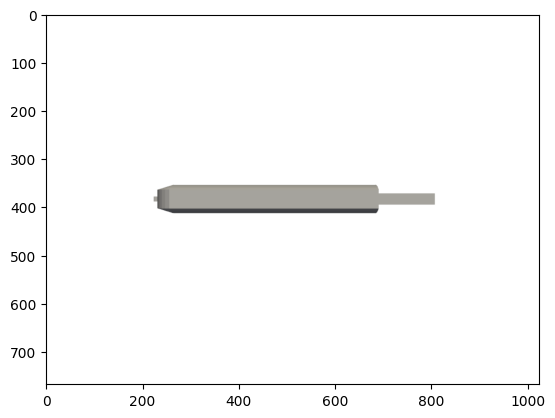

In [115]:
idx, mesh_ids, arrays = cmr.retrieve(text_proj, "text", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view0.png'
img = plt.imread(img_path)
plt.imshow(img)

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(img_proj, "img", "text", top_k=5)
df.iloc[idx[2]]['template1_desc']

'A memorex flash drive which is commonly known as <no_tags>. It is associated with the following characteristics: memory device,storage device.\nA general description of this item is: a device that preserves information for retrieval.'

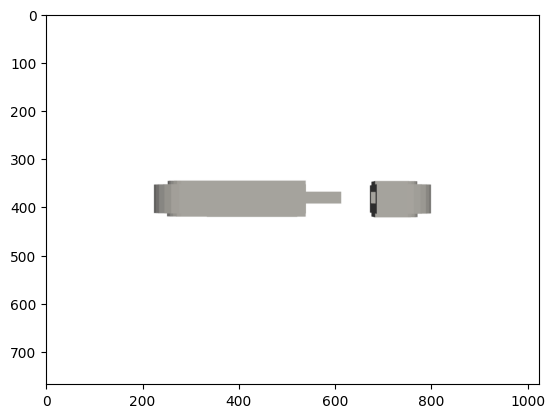

In [ ]:
idx, mesh_ids, arrays = cmr.retrieve(pc_proj, "pc", "img", top_k=5)
img_path = f'Data/ShapeNetSem/Images/subset_200/{mesh_ids[idx[1]]}/view1.png'
img = plt.imread(img_path)
plt.imshow(img)

In [116]:
idx, mesh_ids, arrays = cmr.retrieve(pc_proj, "img", "pc", top_k=5)
mesh_path = f'Data/ProcessedData/PointClouds/{mesh_ids[idx[1]]}.npy'
print(idx, mesh_ids)    

[3, 0, 4, 9, 1] 3    ab82d56cf9cc2476d154e1b098031d39
0      9a9508597dee231d4e205745311c3a
4    353fe70ec5633fc5e05878fff8971272
9    3d15f0b93dc94909ce92f6b720939174
1    71f6598d5426fb34c33dcf45f2780ed8
Name: fullId, dtype: object


In [ ]:
def get_aligned_output(dataset_path, img_dir, pc_dir, prompt, input_modality, output_modality, encoder, cmr):
    df = pd.read_csv(dataset_path)
    projection = encoder.get_projection(prompt, input_modality)
    idx, mesh_ids, arrays = cmr.retrieve(projection, input_modality, output_modality, top_k=5)

    if output_modality == "text":
        output = df.iloc[idx[2]]['template1_desc']
    elif output_modality == "img":
        output = f'{img_dir}{mesh_ids[idx[1]]}/view0.png'
    else:
        output = f'{pc_dir}{mesh_ids[idx[1]]}.obj'
    
    return output

In [2]:
import numpy as np

loss = np.load('TrainedModels/ALIGN/Baseline/loss.npy')
loss[-1]

np.float64(0.007386927402112633)